# This is a lab excercise to recommend relevant Artists to listeners of Last.FM song Website

<html>
<font color = Purple size = 4>
<b> Import required libraries </b>
</font>
</html>

In [1]:
#needed for cloudX lab
from pyspark import SparkContext
from pyspark.sql import SQLContext
sc = SparkContext.getOrCreate()
spark = SQLContext(sc)

In [2]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
import math
from math import sqrt
from pyspark.sql.functions import *
import warnings
warnings.filterwarnings('ignore')
from matplotlib import *
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from pyspark.sql.types import *
from pyspark.sql import Row
import seaborn as sns

<html>
<font color = Purple size = 4>
<b> Import Datasets </b>
</font>
</html>

In [3]:
complete_user_artists_raw_data = sc.textFile('hdfs://ip-172-31-53-48.ec2.internal:8020/data/greatlearning/RS/Lab/user_artists.dat')

In [4]:
type(complete_user_artists_raw_data)

pyspark.rdd.RDD

In [5]:
complete_user_artists_raw_data.take(1)

[u'userID\tartistID\tweight']

In [6]:
complete_user_artists_raw_data = complete_user_artists_raw_data.map(lambda x:x.split("\t"))

<html>
<font color = Purple size = 4>
<b> Thus, we see that the raw data contains 3 fields: userId, ArtistId and listening count. We will use the first three fields to develop recoemmendations. </b>
</font>
</html>

<html>
<font color = Blue size = 4>
<b> Total rating </b>
</font>
</html>

<html>
<font color = Purple size = 4>
<b> As we see above,the first line in the data is header. We will have to ignore it before we create RDD. Else, it will create problems in the analysis. </b>
</font>
</html>

In [7]:
complete_user_artists_data_header = complete_user_artists_raw_data.take(1)[0]

In [8]:
complete_user_artists_data_header

[u'userID', u'artistID', u'weight']

<html>
<font color = Purple size = 4>
<b> In the below, we read the ratings data while ignoring the first record of header and split it using ','. </b>
</font>
</html>

In [9]:
complete_user_artists_data = complete_user_artists_raw_data.filter(lambda line:line!=complete_user_artists_data_header)

In [10]:
complete_user_artists_data = complete_user_artists_data.map(lambda x: [x[0], x[1], int(x[2])])

In [11]:
complete_user_artists_data.take(3)

[[u'2', u'51', 13883], [u'2', u'52', 11690], [u'2', u'53', 11351]]

In [12]:
no_of_records = complete_user_artists_data.count()

In [13]:
print "Total number of Records are %d" %  ( no_of_records)

Total number of Records are 92834


<html>
<font color = Purple size = 4>
<b> Let's convert the RDD into Dataframe. </b>
</font>
</html>

In [14]:
weightsDF=complete_user_artists_data.toDF(['user','artist','weight'])

<html>
<font color = Purple size = 4>
<b> Let's do some exploratory analysis. </b>
</font>
</html>

In [15]:
weightsDF.select('weight').describe().show()

+-------+------------------+
|summary|            weight|
+-------+------------------+
|  count|             92834|
|   mean| 745.2439300256372|
| stddev|3751.3220803876743|
|    min|                 1|
|    max|            352698|
+-------+------------------+



In [16]:
weightsPD=weightsDF.toPandas()

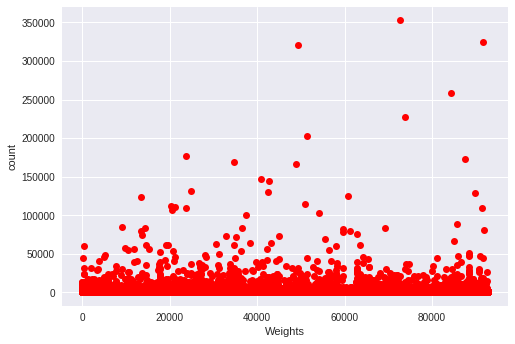

In [17]:
plt.plot(weightsPD['weight'],'ro')
plt.xlabel('Weights')
plt.ylabel('count')
plt.show()

In [18]:
weightsPD.describe()

,weight
count,92834.00000
mean,745.24393
std,3751.32208
min,1.00000
25%,107.00000
50%,260.00000
75%,614.00000
max,352698.00000


In [19]:
weights_count = weightsPD['weight'].groupby(weightsPD['weight']).count()

In [20]:
weights_count.describe()

count    5436.000000
mean       17.077631
std        41.791609
min         1.000000
25%         1.000000
50%         2.000000
75%         9.000000
max       636.000000
Name: weight, dtype: float64

<html>
<font color = DarkBlue>
There are outliers in the above dataset. If we continue building model with outliers, RMSE values will increase between training and test data and Model accuracy will go down. So, let us clean the dataset from outliers before moving further. <br />
75th percentile of data has listening count/weight as 614 where as 100th percentile has 352698 which is clearly indicating that there are outliers beyond 75th percentile. <br />
Now, let us compute the value at 95th percentile and discard records beyond 95th percentile.
</font>
</html>

In [21]:
weightsPD.quantile(0.95)

weight    2328.0
Name: 0.95, dtype: float64

In [22]:
complete_user_artists_cleandata = complete_user_artists_data.filter(lambda x:x[2]<2400)

In [23]:
complete_user_artists_cleandata.take(3)

[[u'2', u'75', 2397], [u'2', u'76', 2382], [u'2', u'77', 2120]]

In [24]:
no_of_cleanrecords = complete_user_artists_cleandata.count()
print "Total number of Records are %d" %  ( no_of_cleanrecords)

Total number of Records are 88398


In [25]:
no_of_users= complete_user_artists_cleandata.map(lambda tokens:(int(tokens[0]))).distinct().count()

In [26]:
complete_user_artists_cleandata.map(lambda x: x[0]).take(3)

[u'2', u'2', u'2']

In [27]:
print "Total number of users in the weights table are %d" % (no_of_users)

Total number of users in the weights table are 1889


In [28]:
no_of_artists= complete_user_artists_cleandata.map(lambda tokens:(int(tokens[1]))).distinct().count()

In [29]:
print "Total number of artists whose songs are wieghted in weights table are %d" % (no_of_artists)

Total number of artists whose songs are wieghted in weights table are 17430


In [30]:
no_of_discards = no_of_records-no_of_cleanrecords

In [31]:
no_of_discards

4436

In [32]:
print "Total number of records discarded due to extreme outliers are %d" % (no_of_discards)

Total number of records discarded due to extreme outliers are 4436


In [33]:
print "Total number of discarded records are %d" %(no_of_discards)

Total number of discarded records are 4436


<html>
<font color = DarkBlue>
Let us re-run the above exploratory analysis now and check if the outliers have come down.
</font>
</html>

In [34]:
weightsDF2=complete_user_artists_cleandata.toDF(['user','artist','weight'])
weightsDF2.select('weight').describe().show()

+-------+------------------+
|summary|            weight|
+-------+------------------+
|  count|             88398|
|   mean|  407.178952012489|
| stddev|456.30363599915546|
|    min|                 1|
|    max|              2398|
+-------+------------------+



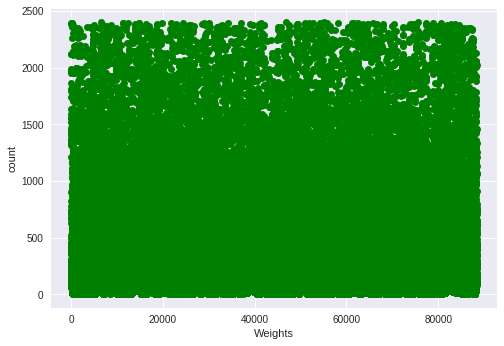

In [35]:
weightsPD2=weightsDF2.toPandas()
plt.plot(weightsPD2['weight'],'ro',color = 'green')
plt.xlabel('Weights')
plt.ylabel('count')
plt.show()

<html>
<font color = Purple size = 4>
<b> Calculate Density </b>
</font>
</html>

In [36]:
density = no_of_cleanrecords/(float(no_of_users)*float(no_of_artists))

In [37]:
print "The density (float) of the rating matrix is %f" % (density)

The density (float) of the rating matrix is 0.002685


In [38]:
print "The density of the rating matrix is %d" % (density)

The density of the rating matrix is 0


<html>
<font color = Purple size = 4>
<b> Divide the data in training and testing part in the ratio 75:25 </b>
</font>
</html>

In [39]:
training, test = complete_user_artists_cleandata.randomSplit([7.5, 2.5], seed=100)

In [40]:
training.take(5)

[[u'2', u'75', 2397],
 [u'2', u'78', 2119],
 [u'2', u'79', 1990],
 [u'2', u'81', 1948],
 [u'2', u'82', 1868]]

<html>
<font color = Purple size = 4>
<b> Build ALS Model </b>
</font>
</html>

In [41]:
rank = 3
seed = 100
iterations = 10
regularization_parameter = 0.05

In [42]:
model = ALS.train(training, rank = rank, seed=seed, iterations=iterations, lambda_=regularization_parameter)

<html>
<font color = Purple size = 4>
<b> Prediction on training data to check the model accuracy </b>
</font>
</html>

In [43]:
predict_train = training.map(lambda x: (x[0],x[1]))

In [44]:
predictall_train = model.predictAll(predict_train).map(lambda  x: ((x[0],x[1]),x[2]))

In [45]:
predictall_train.take(5)

[((1061, 7532), 1677.3795346903387),
 ((507, 7532), 480.663743687041),
 ((1213, 1084), 61.92392119718846),
 ((31, 1084), 102.40054967572155),
 ((674, 9200), 405.18612748786427)]

<html>
<font color = Purple size = 4>
<b> Join all actual and predicted ratings for training set </b>
</font>
</html>

In [46]:
trainingtoKey = training.map(lambda x: ((int(x[0]), int(x[1])), x[2]))

In [47]:
join_predictall_train = trainingtoKey.join(predictall_train)

<html>
<font color = Purple size = 4>
<b> Check actual vs predicted ratings for first five users </b>
</font>
</html>

In [48]:
join_predictall_train.take(5)

[((1968, 952), (113, 442.12204890637486)),
 ((2025, 163), (1555, 2005.6814197232907)),
 ((1688, 5914), (357, 382.57071211905895)),
 ((1937, 289), (956, 964.8914524837326)),
 ((654, 8960), (61, 33.07349975504091))]

<html>
<font color = Purple size = 4>
<b> Evaluate training model </b>
</font>
</html>

In [49]:
t1 = join_predictall_train.map(lambda r: (r[1][0] - r[1][1])**2)

In [50]:
mseList = t1.collect()

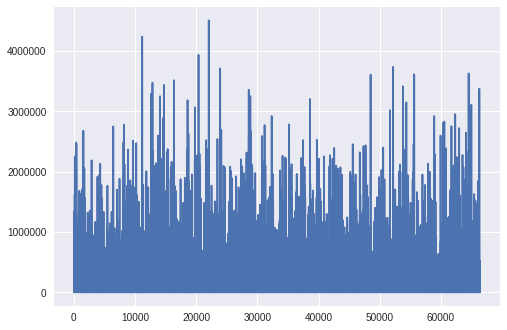

In [51]:
plt.plot(mseList)
plt.show()

In [52]:
MSE_valid = join_predictall_train.map(lambda r: (r[1][0] - r[1][1])**2).mean()

In [53]:
rmse_valid = np.sqrt(MSE_valid)

In [54]:
rmse_valid

238.94198549786739

<html>
<font color = Purple size = 4>
<b> Prediction on Test Data </b>
</font>
</html>

In [55]:
predict_test = test.map(lambda x: (x[0],x[1]))

In [56]:
predictall_test = model.predictAll(predict_test).map(lambda  x: ((x[0],x[1]),x[2]))

<html>
<font color = Purple size = 4>
<b> Model Evaluation on test data </b>
</font>
</html>

In [57]:
testtoKey = test.map(lambda x: ((int(x[0]), int(x[1])), x[2]))

In [58]:
join_predictall_test = testtoKey.join(predictall_test)

In [59]:
join_predictall_test.take(5)

[((711, 707), (238, 277.9149697358698)),
 ((1093, 4069), (61, 98.03683691339347)),
 ((1987, 223), (1545, 241.54605068819183)),
 ((228, 4520), (25, 6.625149597043446)),
 ((628, 450), (97, 94.48531583485686))]

In [60]:
t2 = join_predictall_test.map(lambda r: (r[1][0] - r[1][1])**2)

In [61]:
mseList2 = t2.collect()

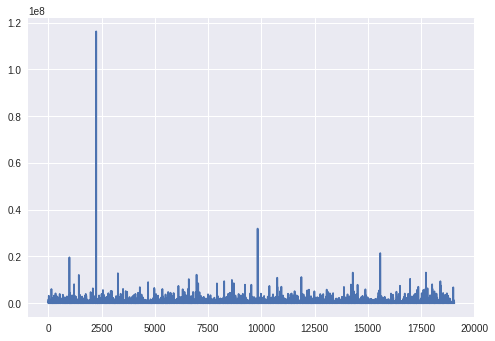

In [62]:
plt.plot(mseList2)
plt.show()

In [63]:
MSE_valid2 = join_predictall_test.map(lambda r: (r[1][0] - r[1][1])**2).mean()

In [64]:
rmse_valid2 = np.sqrt(MSE_valid2)

In [65]:
rmse_valid2

472.94207325982734

In [66]:
print 'For testing data the RMSE is %s' % (rmse_valid2)

For testing data the RMSE is 472.94207326


In [67]:
test.take(3)

[[u'2', u'76', 2382], [u'2', u'77', 2120], [u'2', u'80', 1972]]

In [68]:
predictall_test.take(3)

[((1114, 7532), 481.9213740120101),
 ((1243, 7532), 372.82833634194935),
 ((1781, 6400), 144.94022833035217)]

In [69]:
join_predictall_test.take(5)

[((711, 707), (238, 277.9149697358698)),
 ((1093, 4069), (61, 98.03683691339347)),
 ((1987, 223), (1545, 241.54605068819183)),
 ((228, 4520), (25, 6.625149597043446)),
 ((628, 450), (97, 94.48531583485686))]

#### Even the root mean square errors for Testing data is greater than Training data, the model is still better in its performance.


<html>
<font color = Purple size = 4>
<b> If you want to generate the top recommendations for one user use recommendProducts() </b>
</font>
</html>

<html>
<font color = Purple size = 4>
<b> Recommend top products to user </b>
</font>
</html>

<html>
<font color = DarkBlue>
I am first recommending multiple artists to each user (took 5 users here). <br />
Then I will proceed with steps to recommend to a single user.
</font>
</html>

<html>
<font color = DarkBlue>
<b>Recommend multiple artists to each user using: recommendProductsForUsers() </b>
</font>
</html>

In [70]:
recomm_multiprods_user = model.recommendProductsForUsers(5).take(5)

In [71]:
rec_artist_multiusers = set(recomm_multiprods_user)

In [72]:
rec_artist_multiusers 

{(80,
  (Rating(user=80, product=2185, rating=1536.2795053631414),
   Rating(user=80, product=5017, rating=1418.8116907420808),
   Rating(user=80, product=8756, rating=1343.41787508252),
   Rating(user=80, product=1726, rating=1277.4724283091032),
   Rating(user=80, product=14542, rating=1276.9235919111452))),
 (320,
  (Rating(user=320, product=62, rating=3250.948997604817),
   Rating(user=320, product=14693, rating=2741.931945390159),
   Rating(user=320, product=8715, rating=2731.2193078265664),
   Rating(user=320, product=2185, rating=2651.3869484722563),
   Rating(user=320, product=3483, rating=2616.473603429524))),
 (672,
  (Rating(user=672, product=11688, rating=950.5301342506075),
   Rating(user=672, product=9936, rating=949.1060906405457),
   Rating(user=672, product=9382, rating=918.7830153158707),
   Rating(user=672, product=1332, rating=878.7702028050564),
   Rating(user=672, product=4134, rating=852.1731773767328))),
 (752,
  (Rating(user=752, product=5017, rating=2514.90567

<html>
<font color = DarkBlue>
<b>Recommend multiple artists to any single user using: recommendProducts() </b>
</font>
</html>

In [73]:
#user_id = 51
recomm_to_singleuser = model.recommendProducts(51,10)

In [74]:
rec_artist_singleuser = set(recomm_to_singleuser)

In [75]:
rec_artist_singleuser

{Rating(user=51, product=1332, rating=4750.15693798089),
 Rating(user=51, product=3422, rating=4554.474697711537),
 Rating(user=51, product=3785, rating=3917.7878147528436),
 Rating(user=51, product=4134, rating=4134.277331452972),
 Rating(user=51, product=6194, rating=3594.6470400620547),
 Rating(user=51, product=8707, rating=3594.5986853174477),
 Rating(user=51, product=9382, rating=3863.1591545488),
 Rating(user=51, product=9936, rating=4418.459835450192),
 Rating(user=51, product=11688, rating=4958.607918187041),
 Rating(user=51, product=11689, rating=4142.375887033822)}

<html>
<font color = DarkBlue>
<b>Load artists data to map artist names to artist ids </b>
</font>
</html>

In [76]:
complete_artist_raw_data = sc.textFile('hdfs://ip-172-31-53-48.ec2.internal:8020/data/greatlearning/RS/Lab/artists.dat')
#complete_artist_raw_data = sc.textFile('artists.dat')

In [77]:
complete_artist_raw_data.take(1)

[u'id\tname\turl\tpictureURL']

In [78]:
complete_artist_raw_data = complete_artist_raw_data.map(lambda x:x.split("\t"))

In [79]:
complete_artist_data_header = complete_artist_raw_data.take(1)[0]
complete_artist_data = complete_artist_raw_data.filter(lambda line:line!=complete_artist_data_header)
complete_artist_data = complete_artist_data.map(lambda tokens: (int(tokens[0]),tokens[1])).cache()

In [80]:
artist_data = complete_artist_data.map(lambda x: [x[0],x[1]])

<html>
<font color = DarkBlue>
<b>Print the recommended artists for a single user </b>
</font>
</html>

In [81]:
def ArtistNames(line):
    if line[0] in [recomm_to_singleuser[i][1] for i in range(len(recomm_to_singleuser))]:
        return True
    else:
        return False

recList1 =artist_data.filter(lambda line: ArtistNames(line)).map(lambda x : x[1]).collect()
recList1

[u'XP8',
 u'Autumn',
 u'Spazz',
 u'Claire Voyant',
 u'Leathermouth',
 u'Ludov',
 u'Yelawolf',
 u'Yashin',
 u'\uc7a5\uadfc\uc11d',
 u'\ubbfc\ud638']

<html>
<font color = Purple size = 4>
<b> Recommend top users </b>
</font>
</html>

<html>
<font color = DarkBlue>
<b> I will now recommend multiple users for each Artist using recommendUsersForProducts() </b>
</font>
</html>

In [82]:
recomm_multiusers_eachartist = model.recommendUsersForProducts(5).take(100)

In [83]:
type(recomm_multiusers_eachartist)

list

In [84]:
recomm_multiusers_eachartist[0:5]

[(9200,
  (Rating(user=855, product=9200, rating=570.1442047272882),
   Rating(user=232, product=9200, rating=563.8867761043575),
   Rating(user=1210, product=9200, rating=532.2885439050583),
   Rating(user=107, product=9200, rating=529.5467181843226),
   Rating(user=2072, product=9200, rating=431.93235168916954))),
 (17984,
  (Rating(user=1533, product=17984, rating=1243.023548125302),
   Rating(user=778, product=17984, rating=1189.8987447219183),
   Rating(user=2031, product=17984, rating=1103.8234921273352),
   Rating(user=1504, product=17984, rating=1084.324824676714),
   Rating(user=455, product=17984, rating=1083.668583853767))),
 (3456,
  (Rating(user=104, product=3456, rating=2993.4420117351424),
   Rating(user=855, product=3456, rating=2668.758684263352),
   Rating(user=107, product=3456, rating=2627.856262386688),
   Rating(user=1961, product=3456, rating=2615.733364711322),
   Rating(user=2072, product=3456, rating=2404.7755352275817))),
 (6400,
  (Rating(user=2031, product=

<html>
<font color = DarkBlue>
<b> I will now recommend multiple users for a single Artist using recommendUsers() </b>
</font>
</html>

In [85]:
#Artist_id = 13968
recomm_multiusers_singleartist = model.recommendUsers(13968,100)

In [86]:
type(recomm_multiusers_singleartist)

list

In [87]:
recomm_multiusers_singleartist[0:5]

[Rating(user=104, product=13968, rating=2531.172598146277),
 Rating(user=1961, product=13968, rating=2341.236281958634),
 Rating(user=2031, product=13968, rating=2278.7376099175717),
 Rating(user=2072, product=13968, rating=2159.648603605774),
 Rating(user=621, product=13968, rating=2152.8984087798744)]